In [638]:
import numpy as np
from skimage import io
from skimage import color
import util as ut
import math
import matplotlib.pyplot as plt
from skimage import util as skutil
import cv2
from PIL import Image

# Verkehrsschilderkenner

1) Kontrastanpassung & Kantendetektion
2) Objekte erkennen (Dreiecke, Kreise,...)
3) Auf ein Demo/Standard-schild transformieren
4) Hintergrund weiß setzen
5) Erkennen um welches Schild es sich handelt

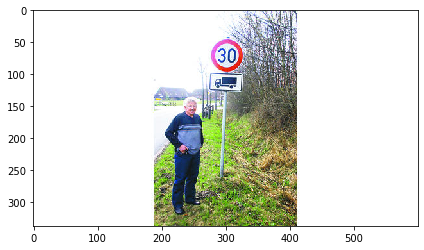

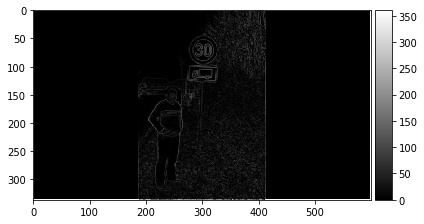

"\nimage_gray = ut.rgb2gray(img_1).astype('uint8')\nedges = cv2.Canny(image_gray, threshold1=100, threshold2=300)\nkernel = np.ones((5,5),np.uint8)\ndilate = cv2.dilate(edges,kernel,iterations = 2)\nerosion = cv2.erode(dilate,kernel,iterations = 1)\nedges = erosion\nut.printImage(erosion)\n"

In [639]:
#img_1 = io.imread("Verkehrsschilderkenner/Verkehrsschilder.jpg")
#img_1 = io.imread("Verkehrsschilderkenner/30_test.jpg")
#img_1 = io.imread("Verkehrsschilderkenner/30_ref.jpg")
img_1 = io.imread("Verkehrsschilderkenner/30_test_3.jpg")
#img_1 = io.imread("Verkehrsschilderkenner/test.jpg")
ut.printImage(img_1,False)

img_1_gray = ut.rgb2gray(img_1)
# image = img_1_gray.astype('uint8')

# Kantendetektion
imgOut_gradient = ut.gradient(img_1_gray)
ut.printImage(imgOut_gradient)
# image = imgOut_gradient.astype('uint8')

# Image.fromarray(imgOut_gradient).convert("RGB").save('Gradient_Version.jpg')

# Version 2 mit Canny
'''
image_gray = ut.rgb2gray(img_1).astype('uint8')
edges = cv2.Canny(image_gray, threshold1=100, threshold2=300)
kernel = np.ones((5,5),np.uint8)
dilate = cv2.dilate(edges,kernel,iterations = 2)
erosion = cv2.erode(dilate,kernel,iterations = 1)
edges = erosion
ut.printImage(erosion)
'''

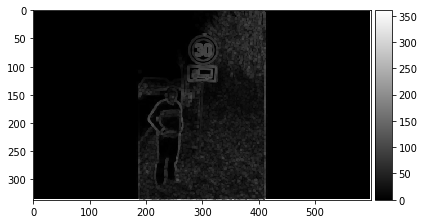

In [640]:
# Rauschen ausbessern durch Morphologische Filter
full = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])

# img_circles = ut.erode(imgOut_gradient, full, 1)
#img_circles = ut.erode(img_circles, fullcircle, 1)
img_circles = ut.dilate(imgOut_gradient, full, 1)
#img_circles = ut.dilate(img_circles, full, 1)
ut.printImage(img_circles)

#image = (img_1_gray).astype('uint8')
#image = (imgOut_gradient).astype('uint8')
#image = (imgOut_1).astype('uint8')
#image = (img_1).astype('uint8')
image = (img_circles).astype('uint8')

# Image.fromarray(img_circles).convert("RGB").save('Gradient_Version.jpg')

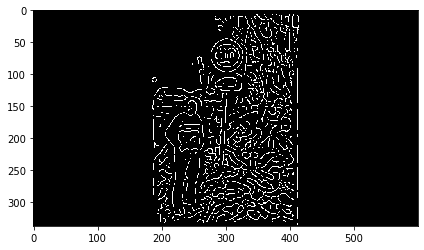

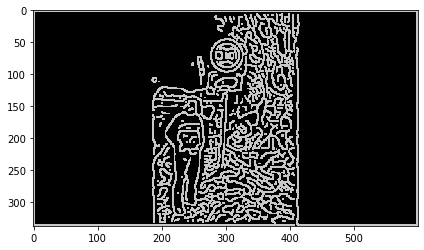

In [641]:
from skimage.feature import canny

edges = canny(img_1_gray, sigma=3.0, low_threshold=0.25, high_threshold=0.8)
# edges = cv2.Canny(img_1_gray, threshold1=100, threshold2=300)
ut.printImage(edges)

edges = ut.dilate(edges, full, 1)
#edges = ut.erode(edges, full, 1)

edges = edges * 200
edges = edges.astype('uint8')
ut.printImage(edges)

#### Detect Triangles

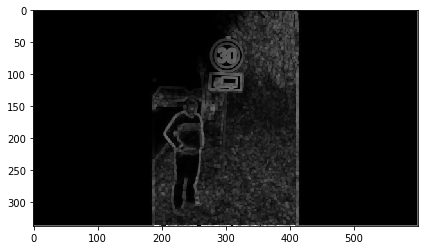

Number of Triangular Blobs: 1


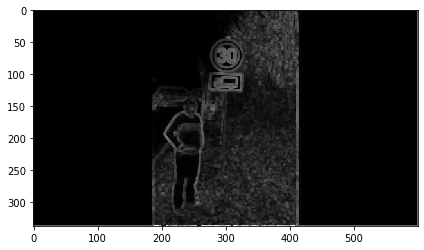

In [642]:
def detect_triangle(img):
    img = img.copy()
    ut.printImage(img)

    params = cv2.SimpleBlobDetector_Params()

    params.filterByArea = True
    params.minArea = 2000
    params.maxArea = 100000000

    params.filterByColor = False
    params.blobColor = 255

    params.filterByConvexity = True
    params.minConvexity = 0.3

    params.filterByCircularity = True
    params.minCircularity = 0.55
    params.maxCircularity = 0.7

    params.minThreshold = 10
    params.maxThreshold = 200


    blobdet = cv2.SimpleBlobDetector_create(params)

    scaled_im = 255 - (img.astype(np.float32) * 255 / np.max(img)).astype(np.uint8)
    keypoints = blobdet.detect(scaled_im)

    for k in keypoints:
        k.size *= 1.7

    blank = np.zeros((1, 1))
    blobs = cv2.drawKeypoints(img, keypoints, blank, (0, 255, 0),cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    text = "Number of Triangular Blobs: " + str(len(keypoints))
    print(text)

    ut.printImage(blobs)
    return keypoints


keypoints_triangle = detect_triangle(image)

#### Detect Circles

Number of Circular Blobs: 1


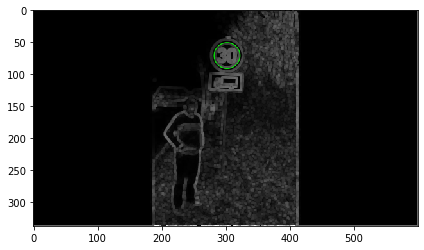

Number of Circular Blobs: 0


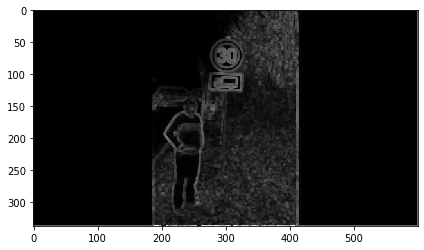

In [643]:
def detect_ellipse(img, minArea, minCircularity, maxCircularity):
    # ut.printImage(img)
    params = cv2.SimpleBlobDetector_Params()

    params.filterByColor = False
    #params.blobColor = 255

    params.filterByArea = True
    params.minArea = minArea #20000 #1000
    params.maxArea = 100000000

    params.filterByCircularity = True
    params.minCircularity = minCircularity
    params.maxCircularity = maxCircularity

    params.filterByConvexity = True
    params.minConvexity = 0.7

    params.filterByInertia = True
    #params.minInertiaRatio = 0.8
    params.minInertiaRatio = 0.3

    params.minThreshold = 1
    params.maxThreshold = 255

    detector = cv2.SimpleBlobDetector_create(params)

    keypoints = detector.detect(img)

    blank = np.zeros((1, 1))
    blobs = cv2.drawKeypoints(img, keypoints, blank, (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    text = "Number of Circular Blobs: " + str(len(keypoints))
    print(text)

    ut.printImage(blobs)

    return keypoints

def detect_circles(img, minArea):
    return detect_ellipse(img, minArea, 0.8, 1)

keypoints_circle = []
keypoints_circle_1 = detect_circles(image, 1000)
keypoints_circle_2 = detect_circles(image, 20000)
for points in keypoints_circle_1:
    keypoints_circle.append(points)
for points in keypoints_circle_2:
    keypoints_circle.append(points)

#### Detect Ellipses

Number of Circular Blobs: 1


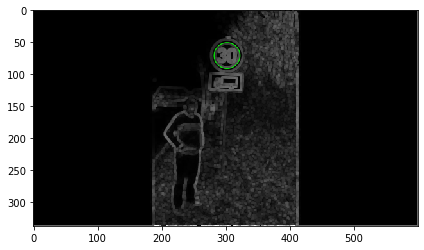

Number of Circular Blobs: 0


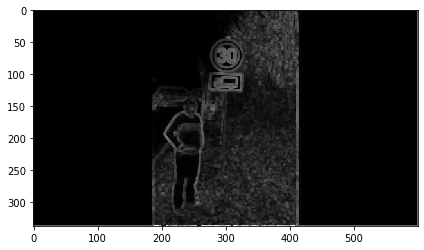

In [644]:
keypoints_TfCircle_1 = detect_ellipse(image, 1000, 0.8, 0.95)
keypoints_TfCircle_2 = detect_ellipse(image, 20000, 0.8, 0.95)

for points in keypoints_TfCircle_1:
    keypoints_circle.append(points)
for points in keypoints_TfCircle_2:
    keypoints_circle.append(points)

    #print(points.angle)
    #print(points.octave)

#### detect everything for canny version

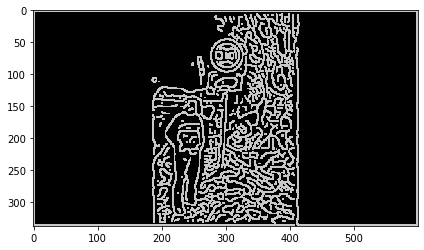

Number of Triangular Blobs: 0


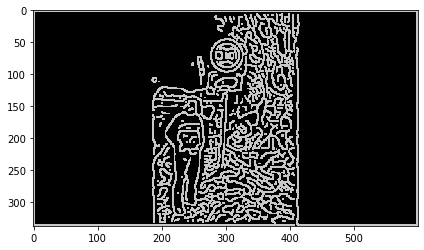

Number of Circular Blobs: 1


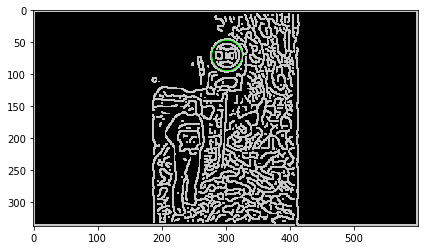

Number of Circular Blobs: 0


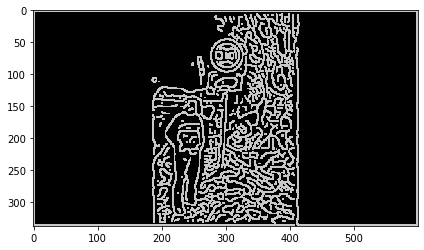

Number of Circular Blobs: 1


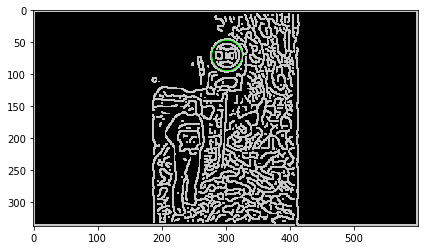

Number of Circular Blobs: 0


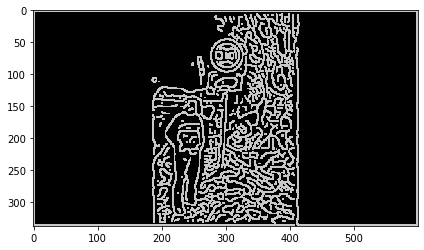

In [645]:
cannyT = detect_triangle(edges)

cannyC_1 = detect_circles(edges, 1000)
cannyC_2 = detect_circles(edges, 20000)

cannyE_1 = detect_ellipse(edges, 1000, 0.8, 0.95)
cannyE_2 = detect_ellipse(edges, 20000, 0.8, 0.95)

cannyPicPoints = []

for points in cannyT:
    cannyPicPoints.append(points)
for points in cannyC_1:
    cannyPicPoints.append(points)
for points in cannyC_2:
    cannyPicPoints.append(points)
for points in cannyE_1:
    cannyPicPoints.append(points)
for points in cannyE_2:
    cannyPicPoints.append(points)

### Erase the Background and just leave the potential signs

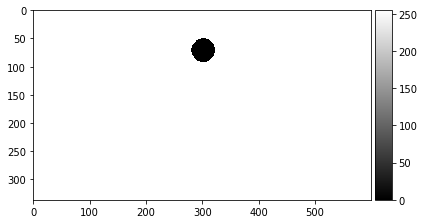

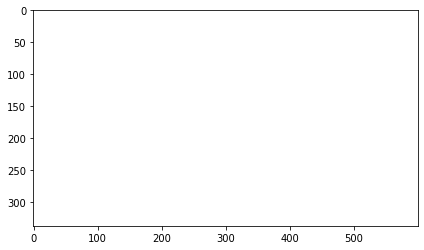

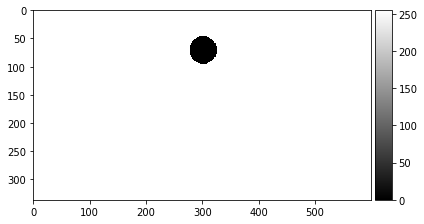

In [646]:
def just_circles(keyP, img):
    img = img.copy()
    empty_img = np.zeros([img.shape[0], img.shape[1]],dtype=np.uint8)
    empty_img.fill(255)

    blank = np.zeros((1, 1))
    blobs = cv2.drawKeypoints(empty_img, keyP, blank, (0,0,0),
                              cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Fill circles
    gray = cv2.cvtColor(blobs, cv2.COLOR_BGR2GRAY)
    #ut.printImage(gray)
    th, im_th = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

    # Copy the thresholded image
    im_floodfill = im_th.copy()

    # Mask used to flood filling.
    # NOTE: the size needs to be 2 pixels bigger on each side than the input image
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0,0), 255)

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground
    circles_inv = im_th | im_floodfill_inv
    circles_pic = 255-circles_inv
    ut.printImage(circles_pic)

    return circles_pic


# Leave just the circles in the picture
circles = just_circles(keypoints_circle, image)
triangles = just_circles(keypoints_triangle, image)
cannys = just_circles(cannyPicPoints, image)

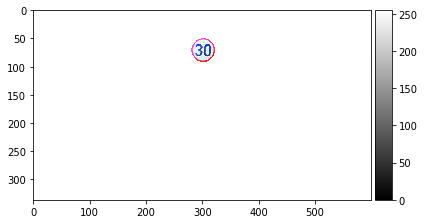

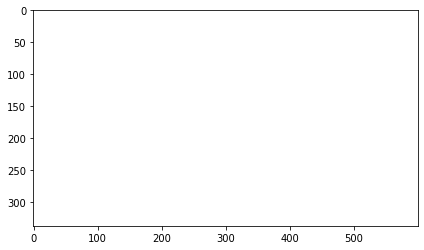

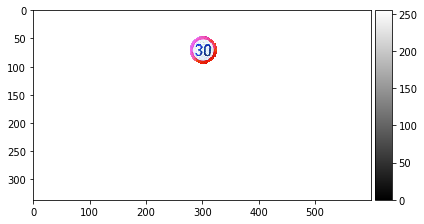

In [647]:
def blobsOnImg(img, blobPic):
    # Blobb Maske auf Ursprüngliches Bild anwenden
    #img = img.copy()
    blank = np.zeros(img.shape, int)
    blank = 255-blank
    #inv = 255-blobPic
    width = img.shape[0]
    height = img.shape[1]
    for i in range(width):
        for j in range(height):
            if (blobPic[i][j] != 255):
                blank[i][j] = img[i][j]
    ut.printImage(blank)

    # Kreise in Areas teilen
    #circles_bin = ut.to_bin(inv)
    #ut.printImage(circles_bin,False)

    #ut.sequential_labelling(circles_bin, False)
    return blank

blobImg = blobsOnImg(img_1, circles)
triImage = blobsOnImg(img_1, triangles)
cannyImage = blobsOnImg(img_1, cannys)

#### Teile Areas in einzelne Bilder

In [648]:
def zoom(img, keypoints):
    set = list()
    #img = img.copy()
    #img = cv2.drawKeypoints(img, keypoints, img, (0, 255, 0))
    for kp in keypoints:
        minX = int(kp.pt[0]-kp.size/2)
        maxX = int(kp.pt[0]+kp.size/2+1)
        minY = int(kp.pt[1]-kp.size/2)
        maxY = int(kp.pt[1]+kp.size/2+1)
        # print(minX, maxX, minY, maxY)

        set.append(img[minY:maxY,minX:maxX])
    return set


zoomCircles = zoom(blobImg, keypoints_circle)
zoomTriangles = zoom(triImage, keypoints_triangle)
zoomCannys = zoom(cannyImage, cannyPicPoints)

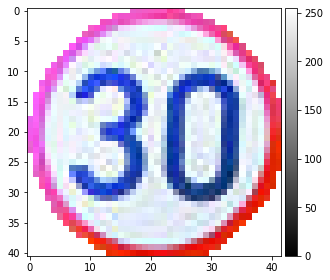

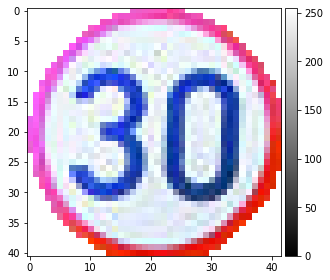

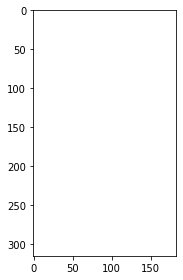

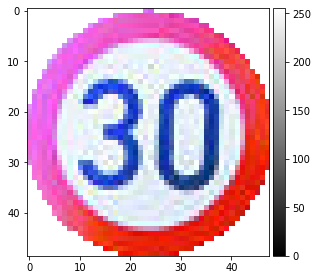

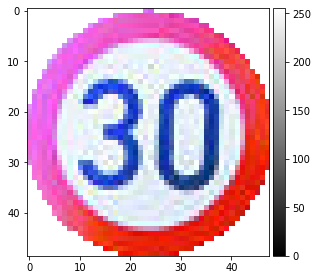

In [649]:

for pics in zoomCircles:
    ut.printImage(pics)
for pics in zoomTriangles:
    ut.printImage(pics)
for pics in zoomCannys:
    ut.printImage(pics)

## Vergleichen von Bildern

In [650]:
def get_ref_spectrum(ref):
    spec = np.zeros(len(ref))
    for i in range(len(ref)):
        for pxl in ref[i]:
            if pxl < 150:
                spec[i] += 1
    return spec

def maximize_contrast(img):
    min_v = np.min(img)
    print(min_v)
    max_v = np.max(img)
    print(max_v)
    for i in range(len(img)):
        for j in range(len(img[0])):
            img[i][j] = (img[i][j] - min_v) / max_v * 255
    return img

def resize_histo(histo, size):
    result = np.zeros(size)
    for i in range(len(histo)):
        idx = round(i / len(histo) * size)
        idx -= 1 if idx >= size else 0
        result[idx] += histo[i]
    for i in range(1, len(result) - 1):
        if result[i] > 1.8 * result[-i] or result[i] > 1.8 * result[i + 1] or result[i] > 1.8 * result[i - 1]:
            result[i] = result[i + 1]
    return result

In [651]:
def match_spectrum(test, ref, limit, debug=False):
    ref_mod = maximize_contrast(ref)

    ref_mod = 255 - ref_mod
    mask = np.zeros((ref_mod.shape[0], ref_mod.shape[1], 3), dtype=np.uint8)
    cv2.circle(mask, (int(ref_mod.shape[0]/2), int(ref_mod.shape[0]/2)), int(ref_mod.shape[0]/2), (255, 255, 255), thickness=-1)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    ref_mod = 255 - cv2.bitwise_and(ref_mod, ref_mod, mask=mask)

    ref_spec = get_ref_spectrum(ref_mod)

    test_mod = maximize_contrast(test)

    test_mod = 255 - test_mod
    mask = np.zeros((test_mod.shape[0], test_mod.shape[1], 3), dtype=np.uint8)
    cv2.circle(mask, (int(test_mod.shape[0]/2), int(test_mod.shape[0]/2)), int(test_mod.shape[0]/2), (255, 255, 255), thickness=-1)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    test_mod = 255 - cv2.bitwise_and(test_mod, test_mod, mask=mask)

    test_spec = get_ref_spectrum(test_mod)
    test_spec = resize_histo(test_spec, len(ref_spec))

    ref_cum = ut.cum_histo(ref_spec)
    test_cum = ut.cum_histo(test_spec)

    cum_diff = ref_cum - test_cum
    # cum_diff = ref_spec / np.max(ref_spec) - test_spec / np.max(test_spec)

    match_result = max(cum_diff) + min(cum_diff) if min(cum_diff) > 0 else max(cum_diff) - min(cum_diff)

    if debug:
        ut.printImage(ref)
        ut.printImage(test)
        ut.printImage(test_mod)
        ut.printHisto(ref_spec)
        ut.printHisto(test_spec)
        ut.printHisto(ref_cum)
        ut.printHisto(test_cum)
        ut.printHisto(cum_diff)
        print(match_result)

    if match_result < limit:
        return True
    else:
        return False

0
255
12
255


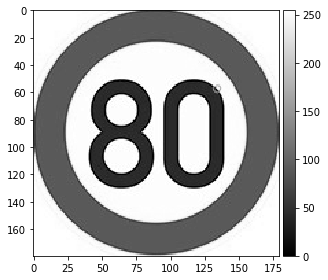

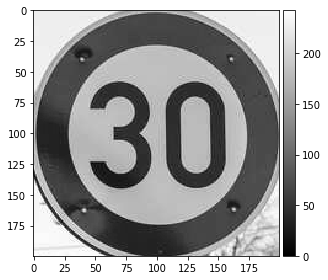

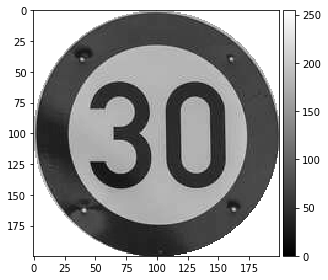

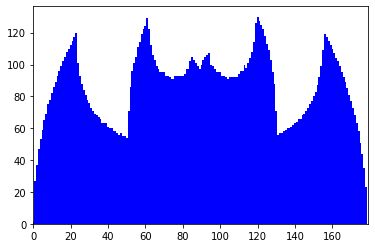

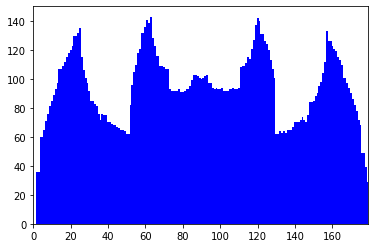

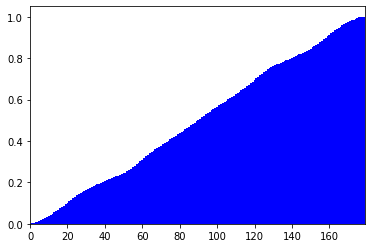

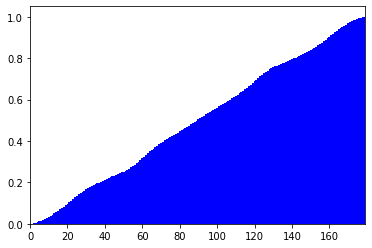

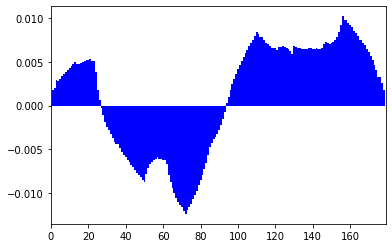

0.022533346442889735
True


In [652]:
img_30_ref = io.imread("Verkehrsschilderkenner/80_ref.jpg", plugin="matplotlib")
img_30_ref = ut.rgb2gray(img_30_ref)

img_30_test = io.imread("Verkehrsschilderkenner/30_test.jpg", plugin="matplotlib")
# img_30_test = io.imread("Verkehrsschilderkenner/30_ref.jpg", plugin="matplotlib")
# img_30_test = io.imread("A1/monkey.jpg", plugin="matplotlib")
img_30_test = ut.rgb2gray(img_30_test)

test_cut_30 = img_30_test[3:203, 243:443]
# test_cut_30 = img_30_test
# ut.printImage(test_cut_30)

print(match_spectrum(test_cut_30, img_30_ref, 0.04, True))

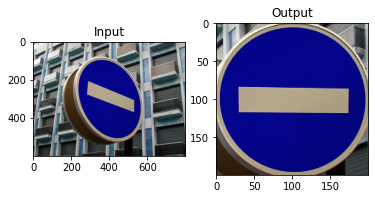

In [653]:
img = cv2.imread('Verkehrsschilderkenner/test.jpg')
rows,cols,ch = img.shape

pts1 = np.float32([[420,100],[570,350],[400,510],[230,220]])
pts2 = np.float32([[100,0],[200,100],[100,200],[0,100]])

M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(img,M,(200,200))

plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()